*Compiled on Jan 6, 2021 with scanpy v.1.6*

# Doublet identification in 10k PBMC dataset using _scrublet_ 

In this notebook, we start with a counts matrix that was processed with `soupX`. The processing is described in a separate R notebook available in the same [repository](https://github.com/cellgeni/notebooks). Overall suggested workflow is described in [ReadTheDocs](https://cellgeni.readthedocs.io/en/latest/).

First, let's import the libraries we're going to use.

In [3]:
import numpy as np
import pandas as pd
import scanpy as sc
import scrublet as scr

Then, read in the counts matrix generated by `soupX`.

In [4]:
adata = sc.read_10x_mtx('soupX_pbmc10k_filt', cache=False)
adata.var_names_make_unique()

Let's take a look at the dataset. The full matrix contains __10194__ cells and __36601__ genes. 

In [5]:
adata

AnnData object with n_obs × n_vars = 10194 × 36601
    var: 'gene_ids'

For the next step, we would need the expected doublet formation rate. These values can be found [here](https://uofuhealth.utah.edu/huntsman/shared-resources/gba/htg/single-cell/genomics-10x.php). Since our dataset has approximately 10,000 (recovered) cells, we take the highest value given in the table.

In [6]:
scrub = scr.Scrublet(adata.X, expected_doublet_rate = 0.076)

Calling the main function, `scrub_doublets`, calculates a score for each cell, and assigns the binary (doublet/singlet) prediction based on this score. We can store this data as metadata in the `adata` object.

In [8]:
adata.obs['doublet_scores'], adata.obs['predicted_doublets'] = scrub.scrub_doublets(min_counts=2, min_cells=3, 
                                                          min_gene_variability_pctl=85, n_prin_comps=30)

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.25
Detected doublet rate = 5.4%
Estimated detectable doublet fraction = 53.5%
Overall doublet rate:
	Expected   = 7.6%
	Estimated  = 10.0%
Elapsed time: 18.4 seconds


The following histogram is an important diagnostic plot. Doublet score threshold should separate the two shoulders of the bimodal distribution. If this is not so, adjust the soublet score cutoff accordingly.

(<Figure size 576x216 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Observed transcriptomes'}, xlabel='Doublet score', ylabel='Prob. density'>,
        <AxesSubplot:title={'center':'Simulated doublets'}, xlabel='Doublet score', ylabel='Prob. density'>],
       dtype=object))

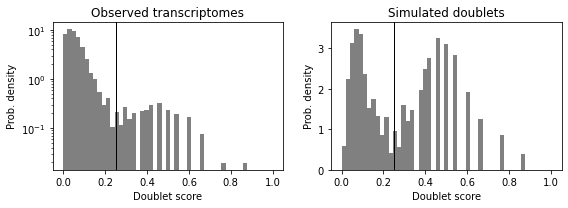

In [9]:
scrub.plot_histogram()

Let's visualize the doublet predictions in a 2-D embedding (e.g., UMAP or t-SNE). Predicted doublets should mostly co-localize (possibly in multiple clusters). If they do not, you may need to adjust the doublet score threshold, or change the pre-processing parameters to better resolve the cell states present in your data. In our case, everything appears to be in order. 

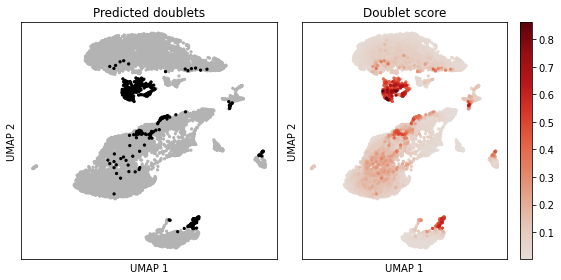

In [10]:
scrub.set_embedding('UMAP', scr.get_umap(scrub.manifold_obs_, 10, min_dist=0.3))
scrub.plot_embedding('UMAP', order_points=True);

Finally, let's save a tab-separated file of doublet calls and doublet scores - it will be used in other notebooks. Otherwise, this data can be used for simple filtering (doublet removal).

In [38]:
adata.obs

,doublet_scores,predicted_doublets
AAACCCACATAACTCG-1,0.305424,True
AAACCCACATGTAACC-1,0.019761,False
AAACCCAGTGAGTCAG-1,0.031399,False
AAACCCAGTGCTTATG-1,0.027550,False
AAACGAACAGTCAGTT-1,0.368680,True
...,...,...
TTTGTTGGTCCGTACG-1,0.029041,False
TTTGTTGGTCGGAACA-1,0.019189,False
TTTGTTGGTTTACGAC-1,0.109827,False
TTTGTTGTCGTTATCT-1,0.040512,False


In [39]:
adata.obs['predicted_doublets'].value_counts()

False    9647
True      547
Name: predicted_doublets, dtype: int64

In [40]:
pd.DataFrame(adata.obs).to_csv("scrublet_calls.tsv",sep = '\t',header = False)